### Imports

In [5]:
import torch, numpy as np, pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (BertConfig, BertTokenizer,
                         BertModel, BartConfig,
                         BartTokenizer, BartForConditionalGeneration)

### Some Configuration

In [6]:
# Dictionary encoding some pretrained (config, tokenizer, model) options we might consider:
model_dict = {'bert-base-uncased': [BertConfig, BertTokenizer, BertModel],
             'bert-base-multilingual-cased': [BertConfig, BertTokenizer, BertModel],
            'facebook/bart-base': [BartConfig, BartTokenizer,BartForConditionalGeneration]
             }

# Choose a huggingface pretrained model from the list above, and maybe other options moving forward
config = {"model_name":'bert-base-uncased'}

# Choose a pretrained mode
pretrained_model = config["model_name"]

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load a pretrained BERT model

In [7]:
# Load tokenizer
tokenizer = model_dict[pretrained_model][1].from_pretrained(pretrained_model)

# Load configuration for bert model; output all hidden states
config = model_dict[pretrained_model][0].from_pretrained(pretrained_model, output_hidden_states=True, use_cache = False, pad_token_id=tokenizer.eos_token_id)

# Load pretrained bert with desired config
model = model_dict[pretrained_model][2].from_pretrained(pretrained_model, config = config)
model.eval()
model = model.to(device)

### Extracting Sentence Embedding Representations

Let's extract the last few hidden state as a sort of high level embedding. Note that by virture of the pretrained model itself, we'll get an embedding per input token when we do this, and we will need to come up with our own determination of how to associate a single embedding to a sentence. In my understanding, this process is not ever done in BERT. We'll then investigate the effect of negating sentences by studying the embeddings associated to (sentence, negation) pairs, e.g. by clustering, studying norm distributions, angle distributions, etc.

In [26]:
def extract_hidden_output(text, model = model, tokenizer = tokenizer, layer_num = -1,
                         aggregation = 'average', elt_index = None):
    
    if aggregation == 'average' or aggregation == 'elt':
        # tokenize the input
        tokens = tokenizer.encode(text, return_tensors = 'pt')
        tokens = tokens.to(device)
        
        with torch.no_grad():
            # All outputs from the Language model
            outputs = model(tokens)
            # All hidden states
            hidden_states = outputs[1]
            # Hidden state from layer layer_num
            layer = hidden_states[layer_num]
            layer = torch.squeeze(layer)
            
            # Average the embeddings for each token, and return
            if aggregation == 'average':
                if len(layer.shape) > 1:
                    averaged_layer = torch.mean(layer, dim = 0)
                    return averaged_layer
                else:
                    return layer
                
            if aggregation == 'elt':
                assert elt_index is not None, 'Please specify an element index'
                if len(layer.shape) > 1:
                    last_elt = layer[-1]
                    return last_elt
                else:
                    return layer
        
        
    # Return the embeddings for each token
    if aggregation == 'none':
        tokens = tokenizer.encode(
            text, 
            return_tensors = 'pt'
            #,max_length=max_length,
            #pad_to_max_length=True
        )
        tokens = tokens.to(device)
        '''
        TODO: Return all token embeddings, so can study each individually. For any batch processing,
        this may require different sentiments have the same number of tokens (depending on implemenation), 
        so we may want to set a max length for sentences and pad.
        '''
        pass
    

### Comparing Positive and Negative Embeddings

In [27]:
# A statement and one possible negation.
statement = 'This book is bad.'
negation = 'This book is good.'

Let's compute the cosine of the angle between the last layer embeddings associated to the statement and it's negation above:

In [28]:
def compute_cosine(statement1, statement2, aggregation, elt_index = None):
    statement1_vec = extract_hidden_output(statement1, aggregation = aggregation, elt_index = elt_index)
    statement2_vec = extract_hidden_output(statement2, aggregation = aggregation, elt_index = elt_index)
    cosine = torch.dot(statement1_vec, statement2_vec)/(torch.norm(statement1_vec)*torch.norm(statement2_vec))
    return cosine


compute_cosine(statement, negation, aggregation = 'average')

tensor(0.9955, device='cuda:0')

#### Using the Stanford real-life contradictions dataset

In [29]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Downloaded 'real-life contradictions' dataset from https://nlp.stanford.edu/projects/contradiction/
tree = ET.parse('data/real_contradiction.xml')
root = tree.getroot()

In [30]:
# Extract contradiction pairs from the XML
pairs = []
for child in root:
    pair =[]
    attrib = child.attrib
    if (attrib['contradiction'] =='YES') & \
    ((attrib['type'] == 'lexical') | (attrib['type'] == 'negation')):
        for statement in child:
            pair.append(statement.text)
    pairs.append(pair)
    
# Remove empty rows
pairs = [pair for pair in pairs if len(pair)>0]

pairs = pd.DataFrame(pairs, columns = ["statement","negation"])

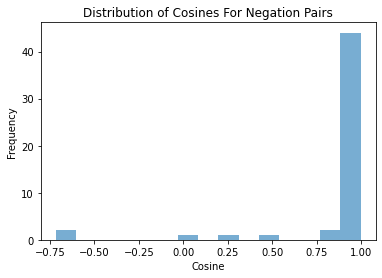

In [31]:
# Store all cosines
cosines = []
for (statement, negation) in zip(pairs.statement.values, pairs.negation.values):
    cosines.append(compute_cosine(statement, negation, aggregation = 'average'))
    
# Plot distribution of cosines among these pairs
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines For Negation Pairs')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()

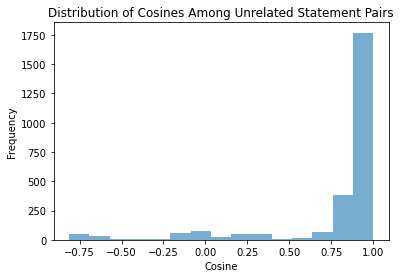

In [32]:
# Store all cosines
cosines = []
for statement1 in pairs.statement.values:
    for statement2 in pairs.statement.values:
        cosines.append(compute_cosine(statement1, statement2, aggregation = 'average'))
    
# Plot distribution of cosines among all statement pairs
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines Among Unrelated Statement Pairs')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()

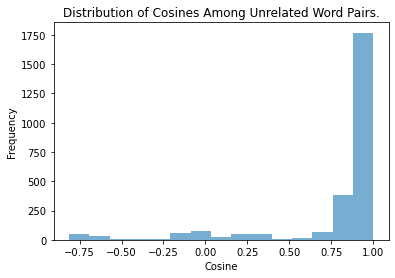

In [33]:
# Store all cosines
cosines = []
for statement1 in pairs.statement.values:
    for statement2 in pairs.statement.values:
        cosines.append(compute_cosine(statement1, statement2, aggregation = 'elt', elt_index = -3))
    
# Plot distribution of cosines among all pairs of last words in the statements
fig, ax = plt.subplots()
plt.hist(torch.stack(cosines).cpu(), bins = 15, alpha = .6)
ax.set_title('Distribution of Cosines Among Unrelated Word Pairs.')
ax.set_xlabel("Cosine")
ax.set_ylabel("Frequency")
plt.show()